<a href="https://colab.research.google.com/github/arielsiman-tov/Intelligent_Forecasting_Engine_For_Stock_Trading-/blob/main/algotrade_project_Intelligent_Forecasting_Engine_for_Stock_Trading_via_Agent_Interface.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Imports**

In [6]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from statsmodels.tsa.arima.model import ARIMA
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import torch
from torch.utils.data import DataLoader, TensorDataset
from statsmodels.tools.tools import add_constant
from sklearn.neighbors import LocalOutlierFactor
from scipy.stats import norm
import tensorflow as tf
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime
import re
from tqdm import tqdm
from tqdm import trange
import matplotlib.dates as mdates
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')


# **BASE CODE + example for AAPL stock**

## **Fetch Data**

In [8]:
def calculate_rsi(prices, window=14):
    '''Relative Strength Index — measures price momentum (overbought/oversold).
     - Measures how much recent gains compare to recent losses
     - Commonly used to identify overbought/oversold conditions
    '''
    delta = prices.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def calculate_macd(prices, fast=12, slow=26, signal=9):
    """Calculate MACD indicator - Measures trend and strength using exponential moving averages.
     - MACD = difference between short and long-term EMAs
     - Signal = EMA of the MACD itself , Helps detect momentum shifts and trend reversals.
    """
    exp1 = prices.ewm(span=fast).mean()
    exp2 = prices.ewm(span=slow).mean()
    macd = exp1 - exp2
    signal_line = macd.ewm(span=signal).mean()
    return macd, signal_line

In [9]:
def download_data(tickers, start="2015-01-01",  end=None):
    '''
    Downloads historical stock data and computes technical indicators and additional features.

    Parameters:
    -----------
    tickers : list or str
        One or more stock tickers (e.g., 'AAPL' or ['AAPL', 'MSFT']) supported by Yahoo Finance.
    start : str, optional
        Start date for the data in 'YYYY-MM-DD' format. Default is '2015-01-01'.
    end : str, optional
        End date for the data in 'YYYY-MM-DD' format. If None, uses today's date.

    Returns:
    --------
    pandas.DataFrame
    '''

    # Downloading the data
    if end is None:
        end = datetime.today().strftime('%Y-%m-%d')
    data = yf.download(tickers, start=start, end=end)
    # Calculating additional metrics
    data['HLP'] = (data['High'] - data['Low']) / data['Low'] * 100.0
    data['GAP'] = (data['Close'] - data['Open']) / data['Open'] * 100.0
    data['HC'] = (data['High'] - data['Close']) / data['Close'] * 100.0
    data['LC'] = (data['Low'] - data['Close']) / data['Close'] * 100.0
    data['RSI'] = calculate_rsi(data['Close'])
    data['MACD'], data['MACD_signal'] = calculate_macd(data['Close'])
    data['Volatility'] = data['Close'].rolling(window=20).std()
    data['VolumeChange'] = data['Volume'].pct_change()
    # Returning only the relevant columns
    return data[['Close', 'HLP', 'GAP', 'HC', 'LC', 'VolumeChange','RSI', 'MACD', 'MACD_signal', 'Volatility']]

#Exampe on AAPL:
tickers = ['AAPL']
raw_data = download_data(tickers)
data_pct = raw_data.pct_change()

[*********************100%***********************]  1 of 1 completed


In [10]:
raw_data

Price,Close,HLP,GAP,HC,LC,VolumeChange,RSI,MACD,MACD_signal,Volatility
Ticker,AAPL,,,,,,,,,
Date,,,,,,,,,,
2015-01-02,24.288580,3.809971,-1.849356,1.929937,-1.811034,NaN,NaN,0.000000,0.000000,NaN
2015-01-05,23.604330,3.073710,-1.883831,2.258825,-0.790585,0.208270,NaN,-0.015352,-0.008529,NaN
2015-01-06,23.606548,2.676100,-0.262811,1.101071,-1.533978,0.023514,NaN,-0.019492,-0.013022,NaN
2015-01-07,23.937561,1.405811,0.513063,0.417631,-0.974481,-0.390461,NaN,-0.008947,-0.011642,NaN
2015-01-08,24.857306,3.173877,2.435225,0.232373,-2.851017,0.480194,NaN,0.033571,0.001808,NaN
...,...,...,...,...,...,...,...,...,...,...
2025-07-18,211.179993,0.996660,0.147009,0.288853,-0.700822,0.018859,70.071509,2.218296,2.080245,4.640863
2025-07-21,212.479996,1.960967,0.179156,1.553089,-0.400033,0.049062,66.338822,2.301326,2.124461,4.507986


## **Data Statistics**

Statistics:
Price         Close          HLP          GAP           HC           LC  \
Ticker         AAPL                                                       
count   2654.000000  2654.000000  2654.000000  2653.000000  2654.000000   
mean       0.000987     0.130180          NaN          inf         -inf   
std        0.018324     0.625375          NaN          NaN          NaN   
min       -0.128647    -0.846515         -inf    -1.000000         -inf   
25%       -0.007436    -0.286497    -2.047288    -0.633921    -0.574514   
50%        0.001001    -0.024023    -1.045293    -0.025765    -0.034734   
75%        0.010099     0.382456    -0.103904     1.747728     1.246223   
max        0.153288     7.505494          inf          inf   293.885080   

Price  VolumeChange          RSI         MACD  MACD_signal   Volatility  
Ticker                                                                   
count   2653.000000  2641.000000  2654.000000  2654.000000  2635.000000  
mean      -1.71

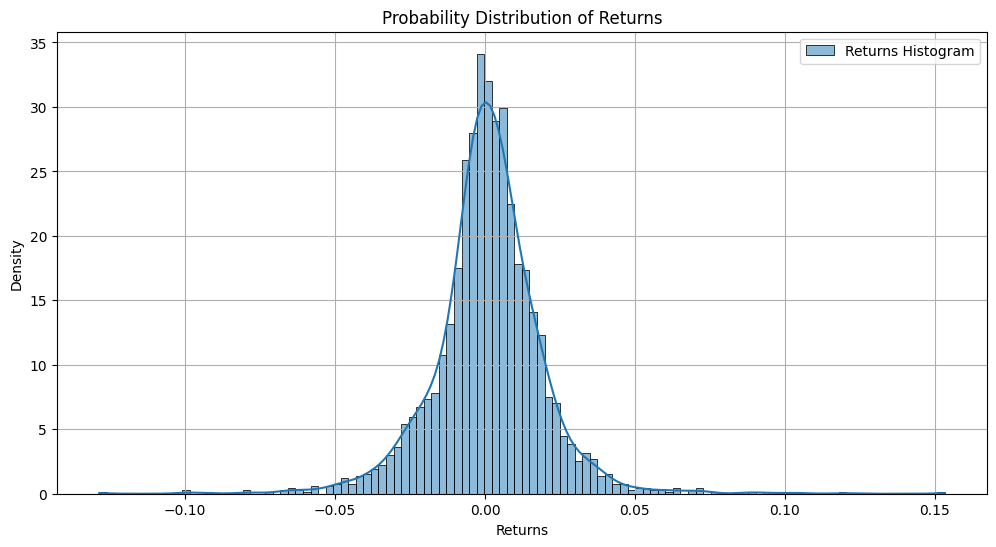

Correlation Matrix:


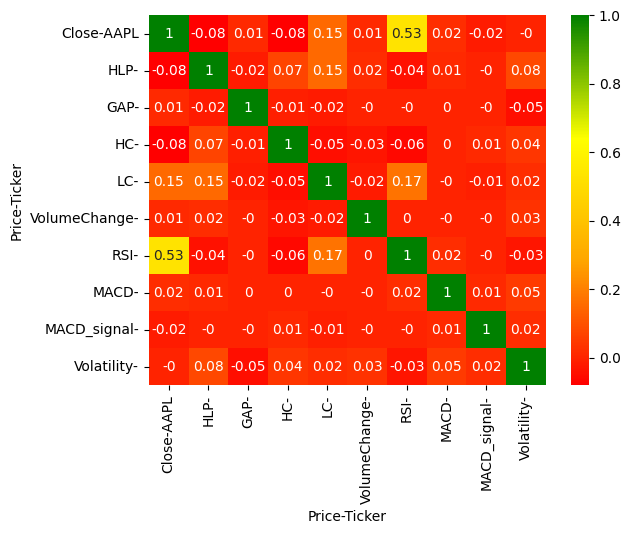

In [11]:
def data_statistics(data):
    """
    Performs statistical analysis and visualization on the given financial dataset.
    Includes descriptive statistics, a probability distribution plot of the 'Close' values,
    and a correlation heatmap.

    Parameters:
    -----------
    data : pd.DataFrame
        A DataFrame containing percentage change values of the stock features,
        including the 'Close' column used for distribution and correlation analysis.

    Output:
    -------
    - Prints descriptive statistics of all columns
    - Displays histogram + KDE of returns (PDF approximation)
    - Displays a heatmap of the correlation matrix among features
    """

    print("Statistics:")
    print(data.describe())

    # Calculate mean and standard deviation of returns
    mean = data['Close'].mean()
    std_dev = data['Close'].std()

    # Calculate probability density function (PDF) for returns
    x = np.linspace(data['Close'].min().min(), data['Close'].max().max(), 1000)
    pdf = norm.pdf(x, mean, std_dev)

    # Plot returns and PDF
    plt.figure(figsize=(12, 6))

    # Plot histogram of returns
    sns.histplot(data['Close'], kde=True, stat="density", label='Returns Histogram', color='blue')

    plt.title('Probability Distribution of Returns')
    plt.xlabel('Returns')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.show()

    print("Correlation Matrix:")
    corr_matrix = data.corr().round(2)
    # Define a colormap going from red → orange → yellow → green
    colors = ['red', 'orange', 'yellow', 'green']
    red_orange_yellow_green = LinearSegmentedColormap.from_list('red_orange_yellow_green', colors)
    sns.heatmap(corr_matrix, annot=True, cmap=red_orange_yellow_green)
    plt.show()


data_statistics(data_pct)

[*********************100%***********************]  5 of 5 completed


Correlation matrix of Close prices for AAPL and indices:

Ticker   AAPL   ^DJI  ^GSPC  ^IXIC   ^RUT
Ticker                                   
AAPL    1.000  0.955  0.974  0.968  0.859
^DJI    0.955  1.000  0.988  0.979  0.929
^GSPC   0.974  0.988  1.000  0.992  0.905
^IXIC   0.968  0.979  0.992  1.000  0.920
^RUT    0.859  0.929  0.905  0.920  1.000


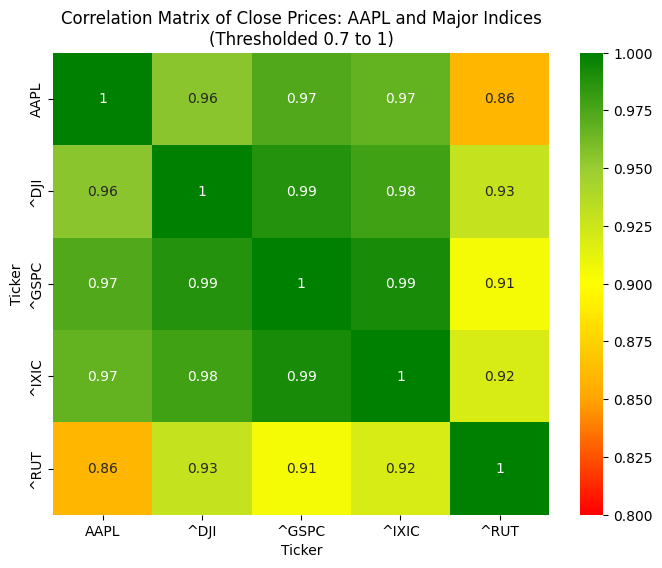

Ticker,AAPL,^DJI,^GSPC,^IXIC,^RUT
Ticker,,,,,
AAPL,1.000000,0.955226,0.974021,0.967800,0.859426
^DJI,0.955226,1.000000,0.987931,0.978503,0.929083
^GSPC,0.974021,0.987931,1.000000,0.991860,0.905057
^IXIC,0.967800,0.978503,0.991860,1.000000,0.919805
^RUT,0.859426,0.929083,0.905057,0.919805,1.000000


In [12]:
def compare_ticker_to_indices(ticker, start_date="2015-01-01", end_date=None):
    """
    Compare the historical closing prices of a given ticker to major US market indices
    and visualize their correlation matrix using a heatmap.

    Parameters:
    -----------
    ticker : str
        The stock ticker symbol to analyze (e.g., 'AAPL', 'MSFT').

    start_date : str, optional (default="2015-01-01")
        The start date for historical data in 'YYYY-MM-DD' format.

    end_date : str or None, optional (default=None)
        The end date for historical data in 'YYYY-MM-DD' format.
        If None, defaults to today's date.

    Returns:
    --------
    corr_matrix : pandas.DataFrame
        A correlation matrix of the closing prices between the input ticker and:
        - S&P 500 (^GSPC)
        - NASDAQ (^IXIC)
        - Dow Jones (^DJI)
        - Russell 2000 (^RUT)

    """
    if end_date is None:
        end_date = datetime.today().strftime('%Y-%m-%d')

    index_tickers = {
        '^GSPC': 'S&P 500',
        '^IXIC': 'NASDAQ',
        '^DJI': 'Dow Jones',
        '^RUT': 'Russell 2000'
    }

    all_tickers = [ticker] + list(index_tickers.keys())
    data = yf.download(all_tickers, start=start_date, end=end_date)['Close']
    data = data.dropna()
    corr_matrix = data.corr()

    print(f"Correlation matrix of Close prices for {ticker} and indices:\n")
    print(corr_matrix.round(3))

    # Clip correlations below 0.7 to 0.7 for color scaling
    corr_clipped = corr_matrix.clip(lower=0.7)

    # Define colormap from red (low=0.7) to green (high=1)
    colors = ['red', 'orange', 'yellow', 'yellowgreen', 'green']
    cmap = LinearSegmentedColormap.from_list('red_to_green', colors)

    plt.figure(figsize=(8, 6))
    sns.heatmap(corr_clipped, annot=True, cmap=cmap, vmin=0.8, vmax=1)
    plt.title(f'Correlation Matrix of Close Prices: {ticker} and Major Indices\n(Thresholded 0.7 to 1)')
    plt.show()

    return corr_matrix

# Usage
ticker = 'AAPL'
compare_ticker_to_indices(ticker)

## **Data Cleaning Process**

In [7]:
def clean_data(data):
    """
    Clean a DataFrame by removing rows with missing values and outliers.
    This function performs two main cleaning steps:
    1. Drops any rows with NaN values.
    2. Removes outliers based on the IQR (Interquartile Range) method.
       A row is considered an outlier if **any** of its values lie outside
       the range [Q1 - 1.5 * IQR, Q3 + 1.5 * IQR] for any column.
    """
    data_clean = data.dropna()  # Remove NaN values
    Q1 = data_clean.quantile(0.25)
    Q3 = data_clean.quantile(0.75)
    IQR = Q3 - Q1
    outliers = ((data_clean < (Q1 - 1.5 * IQR)) | (data_clean > (Q3 + 1.5 * IQR))).sum()
    print("Outliers per column:")
    print(outliers)
    outliers_remove = (data_clean < (Q1 - 1.5 * IQR)) | (data_clean > (Q3 + 1.5 * IQR))
    data_no_outliers = data_clean[~outliers_remove.any(axis=1)]
    return data_no_outliers

data_clean = clean_data(raw_data)
data_clean

Outliers per column:
Price         Ticker
Close         AAPL        0
HLP                     130
GAP                     108
HC                      146
LC                      105
VolumeChange            108
RSI                       0
MACD                    231
MACD_signal             239
Volatility               37
dtype: int64


Price,Close,HLP,GAP,HC,LC,VolumeChange,RSI,MACD,MACD_signal,Volatility
Ticker,AAPL,,,,,,,,,
Date,,,,,,,,,,
2015-01-30,26.028082,2.695765,-1.047295,2.424032,-0.264600,-0.008182,58.434304,0.292845,0.145342,0.798225
2015-02-02,26.354656,2.661954,0.491312,0.455198,-2.149537,-0.250836,66.039683,0.347044,0.186058,0.887261
2015-02-03,26.359102,1.258393,0.126584,0.370834,-0.876528,-0.172514,64.899324,0.385168,0.226176,0.924019
2015-02-04,26.561260,1.859526,0.894513,0.794584,-1.045500,0.351223,66.956242,0.423904,0.265957,0.955307
2015-02-05,26.750843,0.821806,-0.066651,0.241788,-0.575290,-0.397771,75.500225,0.462018,0.305355,1.001488
...,...,...,...,...,...,...,...,...,...,...
2025-07-15,209.110001,1.421597,-0.052577,1.329443,-0.090862,0.088985,67.826770,2.343363,1.932365,5.796340
2025-07-16,210.160004,1.802145,-0.066571,1.065850,-0.723260,0.122805,67.551011,2.290841,2.004061,5.642226


In [8]:
def drop_correlated_features(data, threshold=0.8):
    '''
    Removes highly correlated features based on a threshold, using the upper triangle of the correlation matrix.
    '''
    corr = data.corr().abs()
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool)) #  k==1 means not using the diagonal, includes only the strict upper triangle
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    data_reduced = data.drop(columns=to_drop)
    return data_reduced, to_drop


data_clean_drop_corr, dropped_cols = drop_correlated_features(data_clean)
data_clean_drop_corr

Price,Close,HLP,GAP,HC,LC,VolumeChange,RSI,MACD
Ticker,AAPL,,,,,,,
Date,,,,,,,,
2015-01-30,26.028082,2.695765,-1.047295,2.424032,-0.264600,-0.008182,58.434304,0.292845
2015-02-02,26.354656,2.661954,0.491312,0.455198,-2.149537,-0.250836,66.039683,0.347044
2015-02-03,26.359102,1.258393,0.126584,0.370834,-0.876528,-0.172514,64.899324,0.385168
2015-02-04,26.561260,1.859526,0.894513,0.794584,-1.045500,0.351223,66.956242,0.423904
2015-02-05,26.750843,0.821806,-0.066651,0.241788,-0.575290,-0.397771,75.500225,0.462018
...,...,...,...,...,...,...,...,...
2025-07-15,209.110001,1.421597,-0.052577,1.329443,-0.090862,0.088985,67.826770,2.343363
2025-07-16,210.160004,1.802145,-0.066571,1.065850,-0.723260,0.122805,67.551011,2.290841


In [9]:
dropped_cols

[('MACD_signal', ''), ('Volatility', '')]

# **Models**

### ARIMA

In [10]:
def arima_data_prep(data, target_col='Close', split_ratio=0.95):
    if target_col not in data.columns:
        raise ValueError(f"Column '{target_col}' not found in data.")

    train_size = round(len(data) * split_ratio)
    train_set = data.iloc[:train_size].copy()
    test_set = data.iloc[train_size:].copy()
    return train_set, test_set

def arima_train_and_predict(train_series, test_series, order=(5, 1, 0), verbose=False):
    history = list(map(float, train_series.values.squeeze()))
    predictions = []

    for i, true_value in enumerate(test_series.values.squeeze()):
        try:
            model = ARIMA(history, order=order)
            model_fit = model.fit()
            forecast = model_fit.forecast()[0]
        except Exception as e:
            print(f"[Warning] ARIMA failed at step {i}: {e}")
            forecast = history[-1]

        predictions.append(forecast)
        history.append(true_value)

        if verbose and i % 10 == 0:
            print(f"Step {i}: Predicted={forecast:.2f}, Actual={true_value:.2f}")

    return predictions

def arima_evaluation(train_data, test_data, predictions, target_col='Close', plot=True):
    test_vals = test_data[target_col].values.squeeze()
    predictions = np.array(predictions)

    if len(test_vals) != len(predictions):
        min_len = min(len(test_vals), len(predictions))
        test_vals = test_vals[:min_len]
        predictions = predictions[:min_len]

    mse = np.mean((test_vals - predictions) ** 2)
    rmse = np.sqrt(mse)

    ss_total = np.sum((test_vals - np.mean(test_vals)) ** 2)
    ss_residual = np.sum((test_vals - predictions) ** 2)
    r2 = 1 - (ss_residual / ss_total)

    print(f"\n📊 Evaluation Metrics:")
    print(f"  • RMSE: {rmse:.4f}")
    print(f"  • R²:   {r2:.4f}")

    if plot:
        plt.figure(figsize=(14, 6))

        # Plot training data
        plt.plot(train_data.index, train_data[target_col], label='Training Data', color='blue')

        # Plot actual test data
        plt.plot(test_data.index[:len(test_vals)], test_vals, label='Actual Test Data', color='green')

        # Plot predicted test data
        plt.plot(test_data.index[:len(predictions)], predictions, label='Predicted Test Data', color='red')

        plt.title('ARIMA Model Forecast (Train + Test + Predicted)', fontsize=16)
        plt.xlabel('Date')
        plt.ylabel(f'{target_col} Price')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    test_data = test_data.copy()
    test_data['Predicted'] = predictions
    return test_data

def plot_arima_future_forecast(train_data, test_data, predicted_test, order=(5, 1,0), future_days=30, target_col='Close'):
    """
    Plot the actual last 200 days, predicted test data, and future forecast.

    Parameters:
    - train_data, test_data: DataFrames with actual data
    - predicted_test: np.array or list of predicted values for the test set
    - order: ARIMA order tuple
    - future_days: number of business days to forecast into the future
    - target_col: column name for the target price
    """
    # Combine train + test series for model fitting
    combined_series = pd.concat([train_data[target_col], test_data[target_col]])
    model = ARIMA(combined_series, order=order)
    model_fit = model.fit()

    # Forecast future values
    future_forecast_values = model_fit.forecast(steps=future_days)

    # Prepare dates
    last_date = test_data.index[-1]
    future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=future_days, freq='B')  # Business days

    current_price = float(combined_series.iloc[-1])
    fig, ax_main = plt.subplots(figsize=(14, 6))
    combined_close = combined_series[-200:]
    ax_main.plot(combined_close.index, combined_close.values, label='Actual Close (Last 200 days)', color='blue')
    ax_main.plot(test_data.index, predicted_test, label='Predicted Test Data', color='orange')
    ax_main.plot(future_dates, future_forecast_values, label=f'{future_days}-Day Future Forecast', color='red', linewidth=4)
    ax_main.axhline(current_price, color='black', linestyle='--', alpha=0.6,label=f'Current Price: ${current_price:.2f}')
    ax_main.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m/%Y'))
    plt.setp(ax_main.get_xticklabels(), rotation=45, ha='right')
    ax_main.set_title(f'ARIMA Test Predictions and Future Forecast - Next {future_days} Business Days', fontsize=16)
    ax_main.set_xlabel('Date')
    ax_main.set_ylabel(f'{target_col} Price')
    ax_main.legend()
    ax_main.grid(True)
    fig.tight_layout()
    plt.show()

### SARIMAX (Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors)

In [23]:
def SARIMAX_data_prep(data, target_col='Close', split_ratio=0.95):
    if target_col not in data.columns:
        raise ValueError(f"Column '{target_col}' not found in data.")

    train_size = round(len(data) * split_ratio)
    train_set = data.iloc[:train_size].copy()
    test_set = data.iloc[train_size:].copy()
    return train_set, test_set


def SARIMAX_train_and_predict(train_series, test_series, order=(5, 1, 0), seasonal_order=(0, 0, 0, 0), verbose=False):
    history = list(map(float, train_series.values.squeeze()))
    predictions = []

    for i, true_value in enumerate(test_series.values.squeeze()):
        try:
            model = SARIMAX(history, order=order, seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
            model_fit = model.fit(disp=False)
            forecast = model_fit.forecast()[0]
        except Exception as e:
            print(f"[Warning] SARIMAX failed at step {i}: {e}")
            forecast = history[-1]

        predictions.append(forecast)
        history.append(true_value)

        if verbose and i % 10 == 0:
            print(f"Step {i}: Predicted={forecast:.2f}, Actual={true_value:.2f}")

    return predictions


def SARIMAX_evaluation(train_data, test_data, predictions, target_col='Close', plot=True):
    test_vals = test_data[target_col].values.squeeze()
    predictions = np.array(predictions)

    if len(test_vals) != len(predictions):
        min_len = min(len(test_vals), len(predictions))
        test_vals = test_vals[:min_len]
        predictions = predictions[:min_len]

    mse = np.mean((test_vals - predictions) ** 2)
    rmse = np.sqrt(mse)

    ss_total = np.sum((test_vals - np.mean(test_vals)) ** 2)
    ss_residual = np.sum((test_vals - predictions) ** 2)
    r2 = 1 - (ss_residual / ss_total)

    print(f"\n📊 Evaluation Metrics:")
    print(f"  • RMSE: {rmse:.4f}")
    print(f"  • R²:   {r2:.4f}")

    if plot:
        plt.figure(figsize=(14, 6))
        plt.plot(train_data.index, train_data[target_col], label='Training Data', color='blue')
        plt.plot(test_data.index[:len(test_vals)], test_vals, label='Actual Test Data', color='green')
        plt.plot(test_data.index[:len(predictions)], predictions, label='Predicted Test Data', color='red')
        plt.title('SARIMAX Forecast (Train + Test + Predicted)', fontsize=16)
        plt.xlabel('Date')
        plt.ylabel(f'{target_col} Price')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    test_data = test_data.copy()
    test_data['Predicted'] = predictions
    return test_data


def plot_sarimax_future_forecast(train_data, test_data, predicted_test, order=(5, 1, 0), seasonal_order=(0, 0, 0, 0), future_days=30, target_col='Close'):
    combined_series = pd.concat([train_data[target_col], test_data[target_col]])
    model = SARIMAX(combined_series, order=order, seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
    model_fit = model.fit(disp=False)

    future_forecast_values = model_fit.forecast(steps=future_days)

    last_date = test_data.index[-1]
    future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=future_days, freq='B')

    plt.figure(figsize=(14, 6))
    combined_close = combined_series[-200:]
    plt.plot(combined_close.index, combined_close.values, label='Actual Close (Last 200 days)', color='blue')
    plt.plot(test_data.index, predicted_test, label='Predicted Test Data', color='orange')
    plt.plot(future_dates, future_forecast_values, label=f'{future_days}-Day Future Forecast', color='red', linewidth=3)
    plt.title(f'SARIMAX Test Predictions and {future_days}-Day Forecast', fontsize=16)
    plt.xlabel('Date')
    plt.ylabel(f'{target_col} Price')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

### XGBOOST

In [12]:
class XGBoostTradingModel:
    def __init__(self, n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42):
        """
        Initialize XGBoost model for trading predictions

        Parameters:
        - n_estimators: number of gradient boosted trees
        - max_depth: maximum depth of trees
        - learning_rate: step size shrinkage
        - random_state: random seed for reproducibility
        """
        self.model = xgb.XGBRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            learning_rate=learning_rate,
            random_state=random_state,
            objective='reg:squarederror'
        )
        self.scaler = StandardScaler()
        self.feature_columns = None
        self.is_fitted = False

    def create_features(self, data, lookback_window=5):
        """
        Create features for XGBoost model including lagged features

        Parameters:
        - data: DataFrame with OHLCV and technical indicators
        - lookback_window: number of previous days to use as features
        """
        df = data.copy()

        # Reset index to ensure we have a clean DataFrame
        if df.index.nlevels > 1:
            df = df.reset_index(level=0, drop=True)

        # Use existing technical indicators (based on your actual data structure)
        feature_cols = ['Close', 'HLP', 'GAP', 'HC', 'LC', 'VolumeChange', 'RSI', 'MACD', 'MACD_signal', 'Volatility']

        # Only use columns that exist in the data
        feature_cols = [col for col in feature_cols if col in df.columns]

        # Create lagged features
        for col in feature_cols:
            if col in df.columns:
                for lag in range(1, lookback_window + 1):
                    df[f'{col}_lag_{lag}'] = df[col].shift(lag)

        # Create moving averages for Close price
        if 'Close' in df.columns:
            close_series = df['Close']
            df['Close_ma_5'] = close_series.rolling(window=5).mean()
            df['Close_ma_10'] = close_series.rolling(window=10).mean()
            df['Close_ma_20'] = close_series.rolling(window=20).mean()

            # Create price ratios using a safer method
            # Calculate each ratio separately to avoid DataFrame issues
            ma5_series = df['Close_ma_5']
            ma10_series = df['Close_ma_10']
            ma20_series = df['Close_ma_20']

            # Create ratios with proper error handling
            ratio_ma5 = []
            ratio_ma10 = []
            ratio_ma20 = []

            for i in range(len(close_series)):
                # MA5 ratio
                if pd.notna(ma5_series.iloc[i]) and ma5_series.iloc[i] != 0:
                    ratio_ma5.append(close_series.iloc[i] / ma5_series.iloc[i])
                else:
                    ratio_ma5.append(1.0)

                # MA10 ratio
                if pd.notna(ma10_series.iloc[i]) and ma10_series.iloc[i] != 0:
                    ratio_ma10.append(close_series.iloc[i] / ma10_series.iloc[i])
                else:
                    ratio_ma10.append(1.0)

                # MA20 ratio
                if pd.notna(ma20_series.iloc[i]) and ma20_series.iloc[i] != 0:
                    ratio_ma20.append(close_series.iloc[i] / ma20_series.iloc[i])
                else:
                    ratio_ma20.append(1.0)

            # Assign the calculated ratios
            df['price_to_ma5'] = ratio_ma5
            df['price_to_ma10'] = ratio_ma10
            df['price_to_ma20'] = ratio_ma20

        # Create additional technical features
        if 'RSI' in df.columns:
            df['rsi_overbought'] = (df['RSI'] > 70).astype(int)
            df['rsi_oversold'] = (df['RSI'] < 30).astype(int)

        if 'MACD' in df.columns and 'MACD_signal' in df.columns:
            df['macd_signal_cross'] = (df['MACD'] > df['MACD_signal']).astype(int)

        # Drop rows with NaN values
        df = df.dropna()

        return df

    def prepare_data(self, data, target_col='Close', lookback_window=5):
        """
        Prepare data for training/prediction

        Parameters:
        - data: DataFrame with market data
        - target_col: column name for target variable
        - lookback_window: number of previous days to use as features
        """
        # Create features
        featured_data = self.create_features(data, lookback_window)

        # Separate features and target
        feature_cols = [col for col in featured_data.columns if col != target_col]
        X = featured_data[feature_cols]
        y = featured_data[target_col]

        # Store feature columns for later use
        self.feature_columns = feature_cols

        return X, y, featured_data.index

    def fit(self, train_data, target_col='Close', lookback_window=5):
        """
        Fit the XGBoost model

        Parameters:
        - train_data: DataFrame with training data
        - target_col: column name for target variable
        - lookback_window: number of previous days to use as features
        """
        X_train, y_train, train_index = self.prepare_data(train_data, target_col, lookback_window)

        # Scale features
        X_train_scaled = self.scaler.fit_transform(X_train)

        # Fit the model
        self.model.fit(X_train_scaled, y_train)
        self.is_fitted = True

        return self

    def predict(self, test_data, lookback_window=5):
        """
        Make predictions on test data

        Parameters:
        - test_data: DataFrame with test data
        - lookback_window: number of previous days to use as features
        """
        if not self.is_fitted:
            raise ValueError("Model must be fitted before making predictions")

        X_test, _, test_index = self.prepare_data(test_data, 'Close', lookback_window)

        # Ensure we have the same features as training
        X_test = X_test[self.feature_columns]

        # Scale features
        X_test_scaled = self.scaler.transform(X_test)

        # Make predictions
        predictions = self.model.predict(X_test_scaled)

        return predictions, test_index

    def forecast_future(self, data, forecast_days=20, lookback_window=5):
        """
        Forecast future prices using iterative prediction

        Parameters:
        - data: DataFrame with historical data
        - forecast_days: number of days to forecast
        - lookback_window: number of previous days to use as features
        """
        if not self.is_fitted:
            raise ValueError("Model must be fitted before forecasting")

        # Start with the last available data
        forecast_data = data.copy()
        future_predictions = []

        # Create date range for future predictions
        last_date = forecast_data.index[-1]
        future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=forecast_days)

        for i in range(forecast_days):
            # Prepare features for the current step
            X_current, _, _ = self.prepare_data(forecast_data, 'Close', lookback_window)

            # Use the last row for prediction
            X_current = X_current[self.feature_columns].iloc[-1:]
            X_current_scaled = self.scaler.transform(X_current)

            # Make prediction
            next_price = self.model.predict(X_current_scaled)[0]
            future_predictions.append(next_price)

            # Create new row with predicted price
            new_row = forecast_data.iloc[-1].copy()
            new_row['Close'] = next_price
            new_row.name = future_dates[i]

            # Update other features (simplified approach)
            # In practice, you might want to update technical indicators properly
            if i > 0:
                new_row['HLP'] = (next_price - future_predictions[i-1]) / future_predictions[i-1] * 100
            else:
                # For the first prediction, use the change from last actual price
                last_actual_price = forecast_data['Close'].iloc[-1]
                new_row['HLP'] = (next_price - last_actual_price) / last_actual_price * 100

            # Add the new row to forecast_data
            forecast_data = pd.concat([forecast_data, new_row.to_frame().T])

        return np.array(future_predictions), future_dates

    def get_feature_importance(self, top_n=10):
        """
        Get feature importance from the trained model

        Parameters:
        - top_n: number of top features to return
        """
        if not self.is_fitted:
            raise ValueError("Model must be fitted before getting feature importance")

        importance = self.model.feature_importances_
        feature_importance = pd.DataFrame({
            'feature': self.feature_columns,
            'importance': importance
        }).sort_values('importance', ascending=False)

        return feature_importance.head(top_n)


def evaluate_model(y_true, y_pred, model_name="XGBoost"):
    """
    Evaluate model performance

    Parameters:
    - y_true: actual values
    - y_pred: predicted values
    - model_name: name of the model for printing
    """
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    print(f"\n{model_name} Model Performance:")
    # print(f"MSE: {mse:.4f}")
    # print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R²: {r2:.4f}")
    return {'RMSE': rmse, 'R2': r2}

    # return {'MSE': mse, 'MAE': mae, 'RMSE': rmse, 'R2': r2}


def plot_xgboost_forecast_with_future(train_data, test_data, predictions, future_forecast=None,
                                     future_dates=None, forecast_days=20, historical_days=90,
                                     save_path=None, ticker='Ticker'):
    """
    Create a comprehensive daily market forecast plot based on XGBoost predictions.

    Parameters:
    - train_data: pd.DataFrame with historical training data
    - test_data: pd.DataFrame with test data
    - predictions: array of forecasted close prices for the test set
    - future_forecast: array of future price predictions beyond test set
    - future_dates: DatetimeIndex for future predictions
    - forecast_days: int, number of days forecasted beyond test_data
    - historical_days: int, how many past days to show for context
    - save_path: str or None, path to save plot image
    - ticker: str, ticker symbol for plot title
    """

    # Prepare data
    # recent_data = pd.concat([train_data, test_data]).copy()
    # recent_data = recent_data[-historical_days:].copy()

    # Cut the test_data so its visible part ends where predictions begin
    # Use same length test_data as predictions to avoid misalignment
    aligned_test_data = test_data.iloc[-len(predictions):]

    # Combine for visual context
    recent_data = pd.concat([train_data, aligned_test_data])
    recent_data = recent_data[-historical_days:].copy()

    current_price = float(recent_data['Close'].iloc[-1])

    # Predictions index
    pred_series = pd.Series(predictions, index=test_data['Close'].iloc[-len(predictions):].index)

    # Combine predictions with future forecast
    if future_forecast is not None and future_dates is not None:
        future_series = pd.Series(future_forecast, index=future_dates)
        full_predictions = pd.concat([pred_series, future_series])
    else:
        full_predictions = pred_series

    # Calculate daily returns on forecasted prices
    daily_returns = full_predictions.pct_change().fillna(0) * 100

    # Calculate market metrics
    total_return = ((full_predictions.iloc[-1] - current_price) / current_price) * 100
    max_gain = ((full_predictions.max() - current_price) / current_price) * 100
    max_loss = ((full_predictions.min() - current_price) / current_price) * 100
    volatility = np.std(daily_returns)

    # Trend change points
    trend_changes = []
    pred_vals = full_predictions.values
    for i in range(2, len(pred_vals)):
        if (pred_vals[i] > pred_vals[i-1]) != (pred_vals[i-1] > pred_vals[i-2]):
            trend_changes.append(full_predictions.index[i])

    # Create figure and gridspec
    fig = plt.figure(figsize=(20, 14))
    gs = fig.add_gridspec(3, 2, height_ratios=[3, 1, 1], hspace=0.35, wspace=0.25)

    # Main price plot
    ax_main = fig.add_subplot(gs[0, :])
    ax_main.plot(recent_data.index, recent_data['Close'], label='Historical Close', color='blue')
    ax_main.plot(pred_series.index, pred_series, label='XGBoost Predictions', color='orange', linewidth=2)

    if future_forecast is not None and future_dates is not None:
        ax_main.plot(future_dates, future_forecast, label='Future Forecast', color='red', linewidth=4)

    # Current price horizontal line
    ax_main.axhline(current_price, color='black', linestyle='--', alpha=0.6,
                   label=f'Current Price: ${current_price:.2f}')

    ax_main.set_title(f'{ticker} XGBoost Forecast: {len(predictions)} Days + {forecast_days} Future Days',
                     fontsize=18, fontweight='bold')
    ax_main.set_ylabel('Price ($)')
    ax_main.legend()
    ax_main.grid(True)
    ax_main.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
    plt.setp(ax_main.get_xticklabels(), rotation=45, ha='right')

    # # Daily returns subplot
    # ax_returns = fig.add_subplot(gs[1, 0])
    # colors = ['green' if x >= 0 else 'red' for x in daily_returns]
    # ax_returns.bar(daily_returns.index, daily_returns, color=colors, alpha=0.7)
    # ax_returns.set_title('Forecast Daily Returns (%)')
    # ax_returns.axhline(0, color='black', linewidth=1)
    # ax_returns.grid(True)
    # plt.setp(ax_returns.get_xticklabels(), rotation=45, ha='right')

    # # Risk and summary subplot
    # ax_risk = fig.add_subplot(gs[1, 1])
    # metrics = {
    #     'Total Return (%)': total_return,
    #     'Max Gain (%)': max_gain,
    #     'Max Loss (%)': max_loss,
    #     'Volatility (%)': volatility,
    #     'Trend Changes': len(trend_changes)
    # }
    # keys = list(metrics.keys())
    # vals = list(metrics.values())
    # ax_risk.barh(keys, vals, color='skyblue')
    # ax_risk.set_title('Forecast Summary Metrics')
    # ax_risk.grid(True, axis='x')

    # # Trading recommendation subplot
    # ax_rec = fig.add_subplot(gs[2, :])
    # if total_return > 10:
    #     signal = "STRONG BUY"
    #     color = 'darkgreen'
    # elif total_return > 5:
    #     signal = "BUY"
    #     color = 'green'
    # elif total_return > -5:
    #     signal = "HOLD"
    #     color = 'orange'
    # elif total_return > -10:
    #     signal = "SELL"
    #     color = 'red'
    # else:
    #     signal = "STRONG SELL"
    #     color = 'darkred'

    # ax_rec.text(0.5, 0.6, signal, ha='center', va='center', fontsize=32,
    #            fontweight='bold', color=color, transform=ax_rec.transAxes)
    # ax_rec.text(0.5, 0.4, f'Expected Return: {total_return:.2f}%', ha='center', va='center',
    #            fontsize=18, transform=ax_rec.transAxes)
    # ax_rec.axis('off')
    # ax_rec.set_title('Trading Recommendation', fontsize=20)

    # # Save or show plot
    # if save_path:
    #     plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()


def run_xgboost_trading_model(train_data, test_data, ticker='AAPL', forecast_days=20):
    """
    Complete workflow for XGBoost trading model

    Parameters:
    - train_data: DataFrame with training data
    - test_data: DataFrame with test data
    - ticker: stock ticker symbol
    - forecast_days: number of days to forecast beyond test data
    """

    # Initialize and train the model
    model = XGBoostTradingModel(n_estimators=200, max_depth=8, learning_rate=0.05)

    # Fit the model
    print("Training XGBoost model...")
    model.fit(train_data, target_col='Close', lookback_window=5)

    # Make predictions on test data
    print("Making predictions on test data...")
    predictions, test_index = model.predict(test_data, lookback_window=5)

    # Evaluate model performance
    # actual_test = test_data.loc[test_index, 'Close']
    actual_test = test_data['Close'].iloc[-len(predictions):]
    evaluate_model(actual_test, predictions, "XGBoost")

    # Forecast future prices
    print(f"Forecasting {forecast_days} days into the future...")
    full_data = pd.concat([train_data, test_data])
    future_forecast, future_dates = model.forecast_future(full_data, forecast_days=forecast_days)

    # Display feature importance
    print("\nTop 10 Most Important Features:")
    feature_importance = model.get_feature_importance(top_n=10)
    print(feature_importance)

    # Create the comprehensive plot
    plot_xgboost_forecast_with_future(
        train_data=train_data,
        test_data=test_data,
        predictions=predictions,
        future_forecast=future_forecast,
        future_dates=future_dates,
        forecast_days=forecast_days,
        historical_days=90,
        save_path=None,
        ticker=ticker
    )

    return model, predictions, future_forecast, future_dates

### LSTM

In [25]:
def run_lstm_forecast(data, forecast_days=60, time_steps=60, epochs=20, ticker='AAPL', plot_results=True):
    """
    Train an LSTM model on multivariate time series data and forecast future values.

    Parameters:
    - data: pd.DataFrame, must include 'Close' column
    - forecast_days: int, number of future days to forecast
    - time_steps: int, sequence length for LSTM
    - epochs: int, number of training epochs
    - ticker: str, used for labeling plots
    - plot_results: bool, whether to display plots

    Returns:
    - predictions: np.ndarray, in-sample predictions
    - future_forecast: np.ndarray, forecasted Close prices
    - future_dates: pd.DatetimeIndex, corresponding future dates
    - rmse: float, RMSE on training data
    - r2: float, R² score on training data
    """
    # Step 1: Preprocessing
    scalers = {}
    scaled_data = data.copy()

    if isinstance(scaled_data.columns, pd.MultiIndex):
        scaled_data.columns = [col[0] for col in scaled_data.columns]

    for column in scaled_data.columns:
        scalers[column] = StandardScaler()
        scaled_data[column] = scalers[column].fit_transform(scaled_data[[column]])

    close_index = list(scaled_data.columns).index("Close")

    # Step 2: Sequence creation
    def create_sequences(data_array, time_steps):
        sequences, targets = [], []
        for i in range(time_steps, len(data_array)):
            sequences.append(data_array[i - time_steps:i])
            targets.append(data_array[i, close_index])
        return np.array(sequences), np.array(targets)

    X, y = create_sequences(scaled_data.values, time_steps)
    X = X.reshape((X.shape[0], time_steps, scaled_data.shape[1]))

    # Step 3: Model building
    model = Sequential([
        LSTM(100, return_sequences=True, input_shape=(time_steps, scaled_data.shape[1])),
        Dropout(0.2),
        LSTM(100),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X, y, epochs=epochs, batch_size=32, validation_split=0.1, verbose=0)

    # Step 4: In-sample predictions
    predictions = model.predict(X)
    y_actual = scalers['Close'].inverse_transform(y.reshape(-1, 1))
    predictions = scalers['Close'].inverse_transform(predictions)
    rmse = np.sqrt(mean_squared_error(y_actual, predictions))
    r2 = r2_score(y_actual, predictions)

    # Step 5: Future forecasting
    future_forecast = []
    last_sequence = X[-1]
    for _ in range(forecast_days):
        next_pred = model.predict(last_sequence.reshape(1, time_steps, scaled_data.shape[1]), verbose=0)
        future_forecast.append(next_pred[0, 0])
        next_input = last_sequence[1:].copy()
        next_features = last_sequence[-1].copy()
        next_features[close_index] = next_pred[0, 0]
        next_input = np.vstack([next_input, next_features])
        last_sequence = next_input

    future_forecast = scalers['Close'].inverse_transform(np.array(future_forecast).reshape(-1, 1))
    future_dates = pd.date_range(start=data.index[-1] + pd.Timedelta(days=1), periods=forecast_days, freq='B')

    # Step 6: Plotting
    if plot_results:
        aligned_predictions = np.full(len(data), np.nan)
        aligned_predictions[time_steps:] = predictions.flatten()
        current_price = float(data['Close'].iloc[-1])
        fig, ax = plt.subplots(figsize=(14, 5))
        ax.plot(data.index[-200:], data['Close'].values[-200:], label='Actual Close', color='blue')
        ax.plot(data.index[-200:], aligned_predictions[-200:], label='Predicted Close (Train)', color='orange')
        ax.plot(future_dates, future_forecast, label=f'{forecast_days}-Day Forecast', color='red', linewidth=4)
        ax.axhline(current_price, color='black', linestyle='--', alpha=0.6, label=f'Current Price: ${current_price:.2f}')
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m/%Y'))
        plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
        ax.set_title(f'{ticker} Forecast - Next {forecast_days} Days (Multivariate LSTM)', fontsize=16)
        ax.set_xlabel('Date')
        ax.set_ylabel(f'{ticker} Close Price ($)')
        ax.legend()
        ax.grid(True)
        plt.tight_layout()
        plt.show()

    return predictions, future_forecast, future_dates, rmse, r2

# **Runnig Example On AAPL Stock** (NO NEED TO RUN AGAIN)

**ARIMA**


📊 Evaluation Metrics:
  • RMSE: 3.9397
  • R²:   0.9417


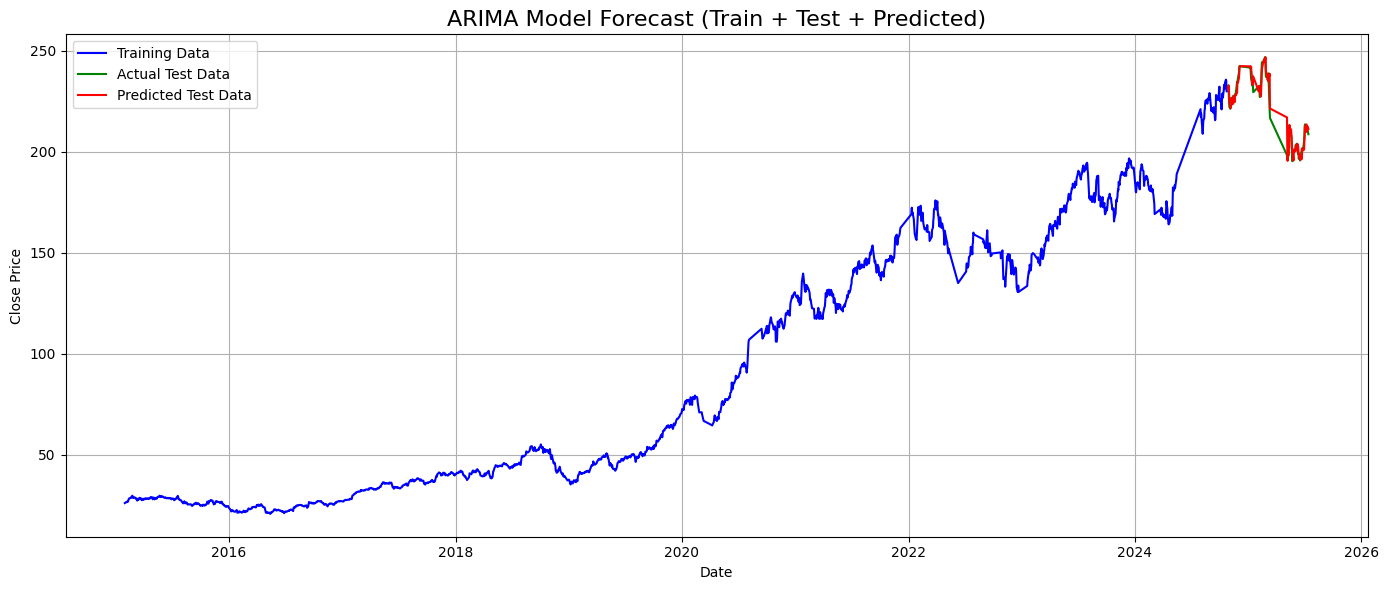

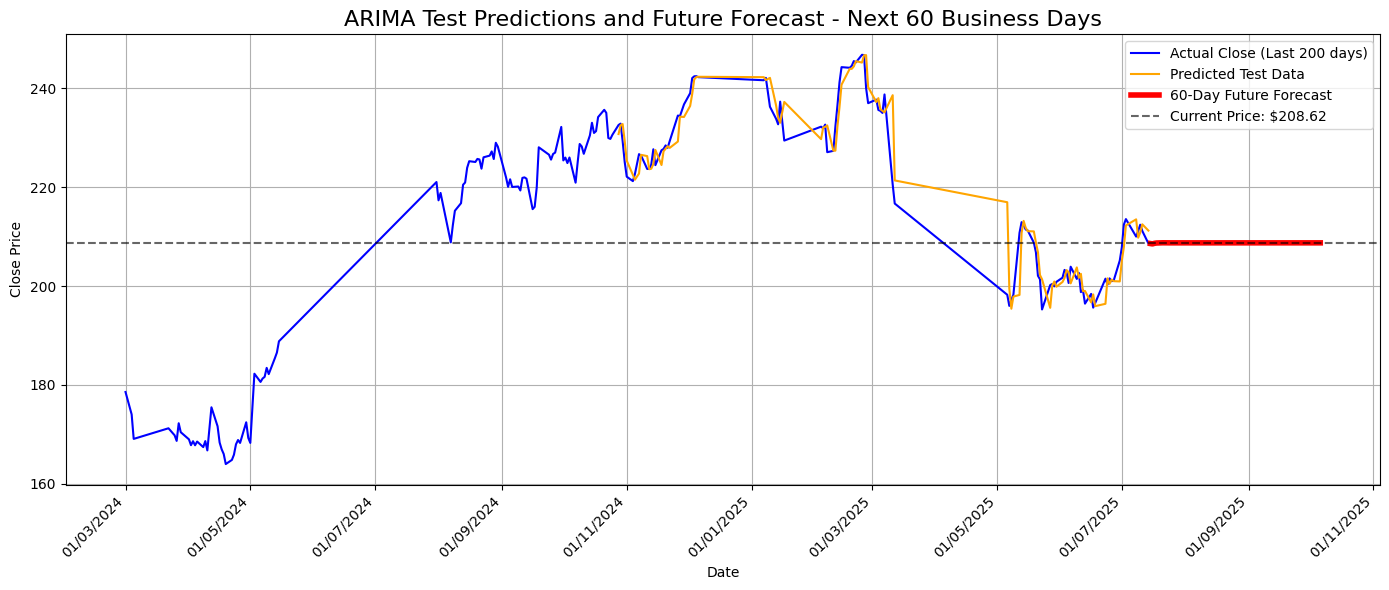

In [ ]:

train_data, test_data = arima_data_prep(data_clean_drop_corr, split_ratio=0.95)
order = (5, 1, 0)
forecasted_values = arima_train_and_predict(train_data['Close'], test_data['Close'], order=order)

# Original plot with train/test/predicted
arima_evaluation(train_data, test_data, forecasted_values, target_col='Close', plot=True)

# New separate future forecast plot
plot_arima_future_forecast(train_data, test_data, forecasted_values, order=order, future_days=60, target_col='Close')

**SARIMAX**


📊 Evaluation Metrics:
  • RMSE: 3.9185
  • R²:   0.9419


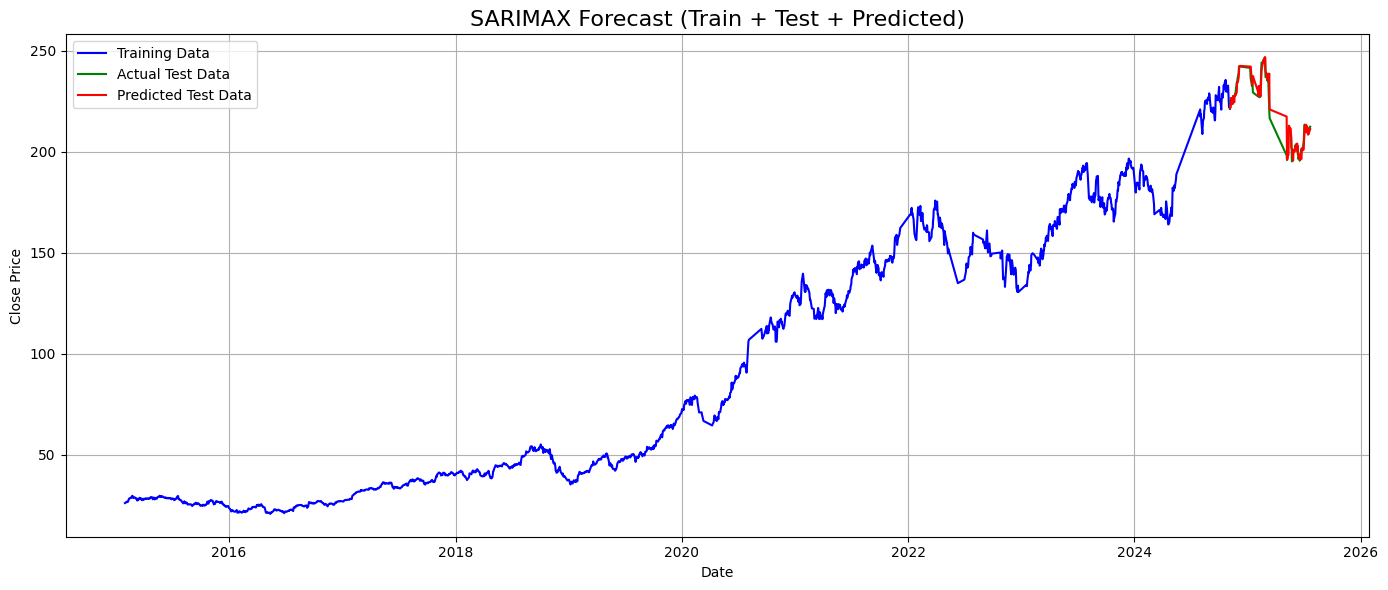

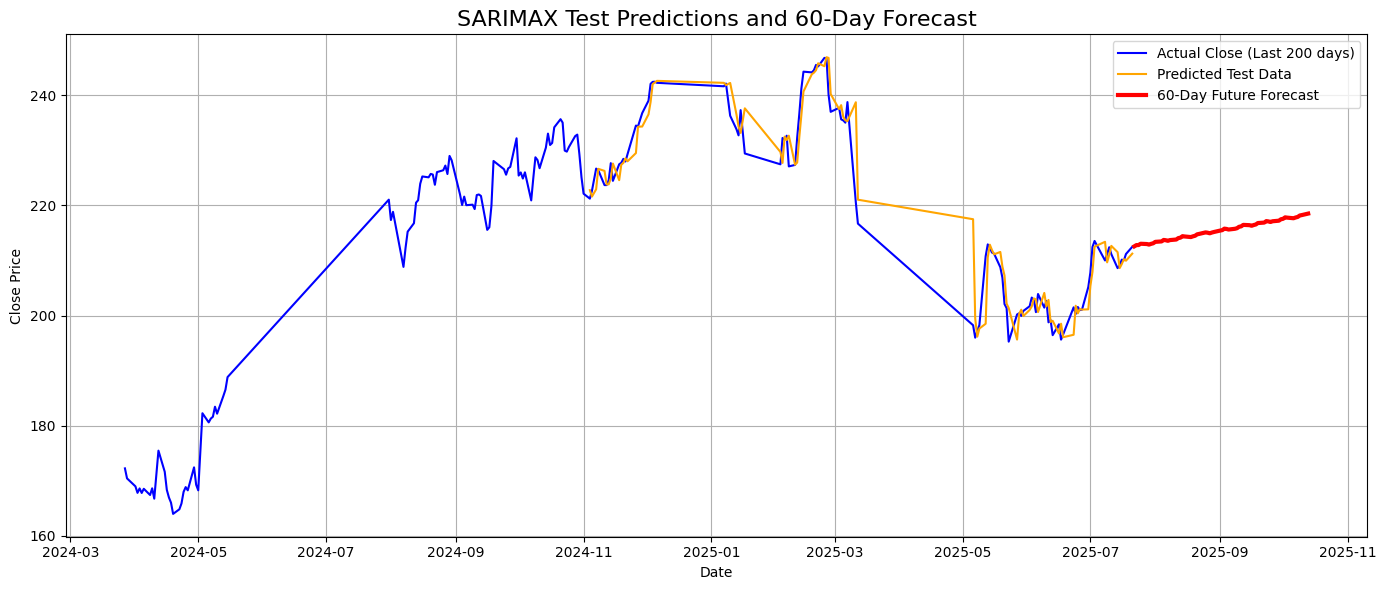

In [24]:
train_data, test_data = SARIMAX_data_prep(data_clean_drop_corr, split_ratio=0.95)
order = (5, 1, 0)
seasonal_order = (1, 1, 1, 7)

forecasted_values = SARIMAX_train_and_predict(
    train_data['Close'],
    test_data['Close'],
    order=order,
    seasonal_order=seasonal_order
)

SARIMAX_evaluation(train_data, test_data, forecasted_values, target_col='Close', plot=True)

plot_sarimax_future_forecast(
    train_data,
    test_data,
    forecasted_values,
    order=order,
    seasonal_order=seasonal_order,
    future_days=60,
    target_col='Close'
)

**XGBOOST**

Training XGBoost model...
Making predictions on test data...

XGBoost Model Performance:
RMSE: 6.2733
R²: 0.8747
Forecasting 60 days into the future...

Top 10 Most Important Features:
            feature  importance
0     (Close, AAPL)    0.730823
48   (Close_ma_5, )    0.249412
10  (Close_lag_3, )    0.012224
8   (Close_lag_1, )    0.002859
9   (Close_lag_2, )    0.002624
12  (Close_lag_5, )    0.000719
47   (MACD_lag_5, )    0.000472
49  (Close_ma_10, )    0.000240
50  (Close_ma_20, )    0.000225
11  (Close_lag_4, )    0.000093


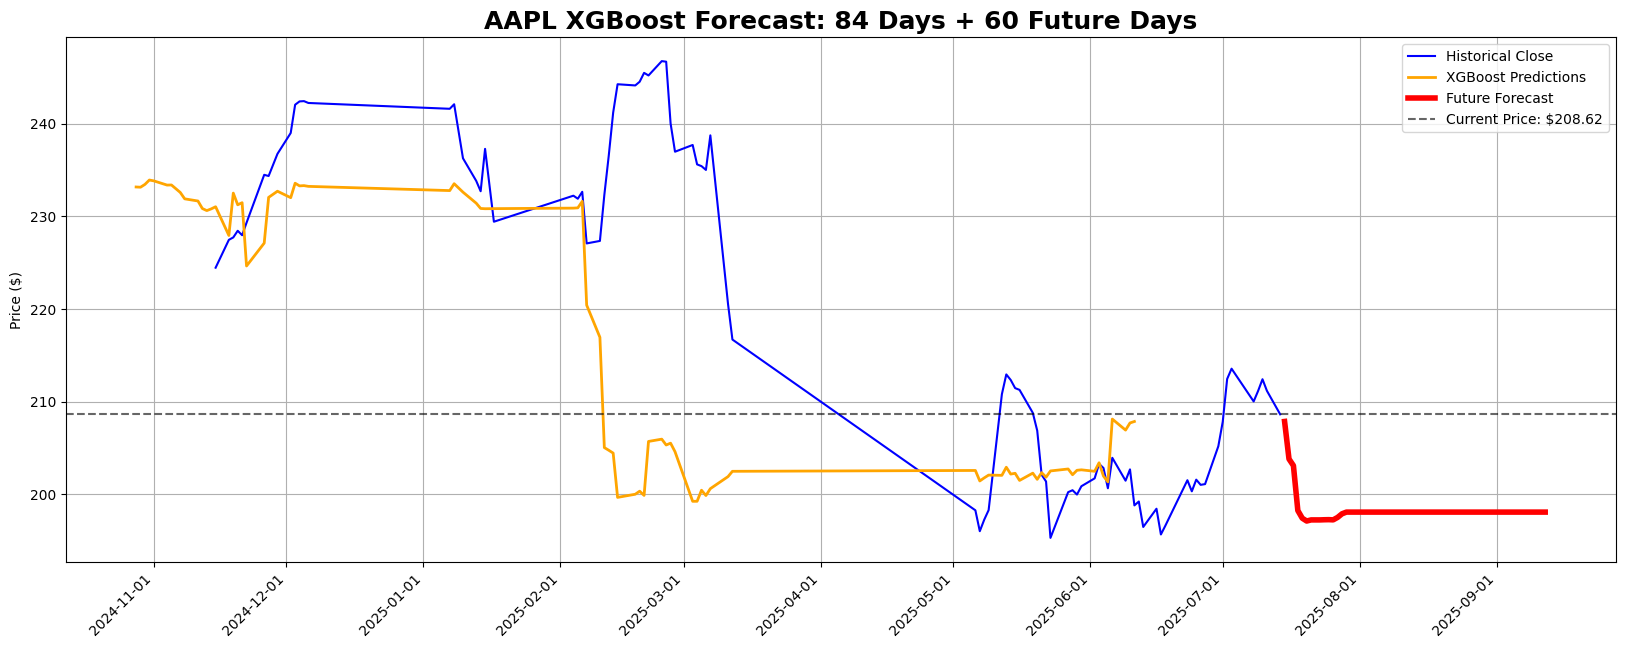

In [ ]:
model, predictions, future_forecast, future_dates = run_xgboost_trading_model(
    train_data=train_data,
    test_data=test_data,
    ticker='AAPL',
    forecast_days=60
)


**LSTM**

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step


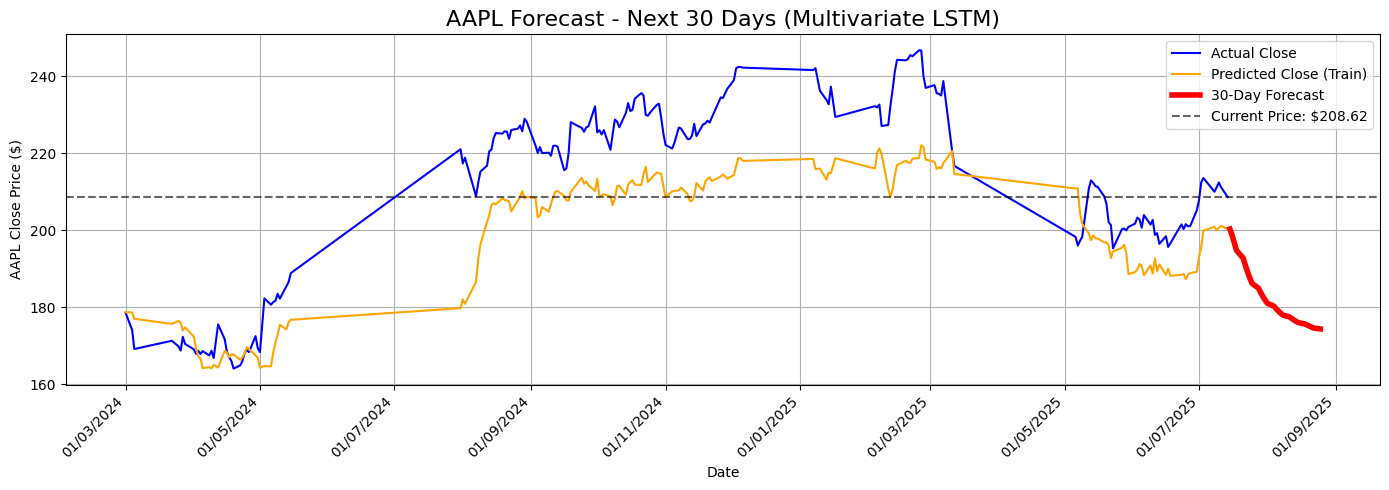

LSTM RMSE: 5.6473, R²: 0.9930


In [ ]:
preds, forecast, dates, rmse, r2 = run_lstm_forecast(
    data=data_clean_drop_corr,
    forecast_days=30,
    time_steps=60,
    epochs=25,
    ticker='AAPL',
    plot_results=True
)
print(f"LSTM RMSE: {rmse:.4f}, R²: {r2:.4f}")

Model Performance Table:
     Model    RMSE      R2
0    ARIMA  3.9397  0.9417
1  SARIMAX  3.9185  0.9419
2  XGBoost  6.2733  0.8747
3     LSTM  5.6473  0.9930


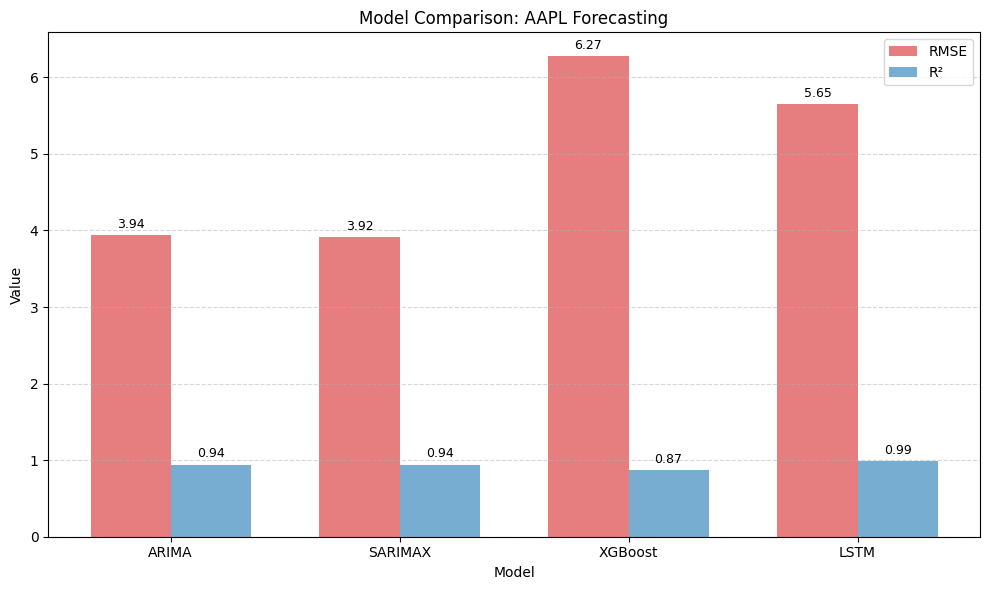

In [30]:
# Create the DataFrame
results_df = pd.DataFrame({
    'Model': ['ARIMA', 'SARIMAX', 'XGBoost', 'LSTM'],
    'RMSE': [3.9397, 3.9185, 6.2733, 5.6473],
    'R2': [0.9417, 0.9419, 0.8747, 0.9930]
})

print("Model Performance Table:")
print(results_df)

# Plotting
x = np.arange(len(results_df['Model']))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 6))

# Bars for RMSE
bars1 = ax.bar(x - width/2, results_df['RMSE'], width, label='RMSE', color='tab:red', alpha=0.6)

# Bars for R² (scaled to same height scale for comparison)
bars2 = ax.bar(x + width/2, results_df['R2'], width, label='R²', color='tab:blue', alpha=0.6)

# Labels and formatting
ax.set_xlabel('Model')
ax.set_ylabel('Value')
ax.set_title('Model Comparison: AAPL Forecasting')
ax.set_xticks(x)
ax.set_xticklabels(results_df['Model'])
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.5)

# Show values on top of bars
for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


# **Agent**

In [14]:
class Style:
    RESET = '\033[0m'
    BOLD = '\033[1m'
    # Basic colors
    RED = '\033[91m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    BLUE = '\033[94m'
    MAGENTA = '\033[95m'
    CYAN = '\033[96m'
    # Custom 256-color safe shades (more muted for white screens)
    DARK_GREEN = '\033[38;5;22m'
    DARK_BLUE = '\033[38;5;18m'
    STEEL_BLUE = '\033[38;5;67m'
    SLATE_GRAY = '\033[38;5;240m'
    DARK_BLUE = '\033[38;5;30m'
    SOFT_PURPLE = '\033[38;5;183m'
    PASTEL_PINK = '\033[38;5;218m'
    ORANGE = '\033[38;5;208m'
    CHARCOAL = '\033[38;5;238m'
    LAVENDER = '\033[38;5;183m'

In [15]:
def run_forecast(ticker='AAPL', forecast_days=30, seq_len=60, epochs=20, model_choice='all', show_future_forecast=True):
    results = {}
    best_rmse = float('inf')
    best_model_name = None
    best_forecast = None
    best_future_dates = None

    print(f"\n{Style.BOLD}{Style.BLUE} Downloading and preparing data for {ticker}...{Style.RESET}")
    data = download_data(ticker)
    print(data.head())

    print(f"\n{Style.BOLD}{Style.BLUE} data_statistics {ticker}...{Style.RESET}")
    data_statistics(data)
    compare_ticker_to_indices(ticker)

    print(f"\n{Style.BOLD}{Style.BLUE} Cleaning and preparing features...{Style.RESET}")
    data_clean = clean_data(data)
    data_clean_drop_corr, dropped = drop_correlated_features(data_clean)
    print(f"\n{Style.BLUE}Dropped correlated features: {dropped}{Style.RESET}")

    print(f"\n{Style.BOLD}{Style.GREEN}---------------------- Start Training Process ------------------------{Style.RESET}")
    train_data, test_data = arima_data_prep(data_clean_drop_corr, split_ratio=0.95)

    model_choice = model_choice.lower()
    # plot_enabled = show_future_forecast and model_choice != 'all'

    # === ARIMA ===
    if model_choice in ['arima', 'all']:
        print(f"\n{Style.BOLD}{Style.DARK_GREEN} Start ARIMA Training {ticker}...{Style.RESET}")
        order = (5, 1, 0)
        arima_preds = arima_train_and_predict(train_data['Close'], test_data['Close'], order=order)
        rmse = np.sqrt(mean_squared_error(test_data['Close'][:len(arima_preds)], arima_preds))
        r2 = r2_score(test_data['Close'][:len(arima_preds)], arima_preds)
        results['arima'] = {'rmse': rmse, 'r2': r2}
        if rmse < best_rmse:
            best_rmse = rmse
            best_model_name = 'ARIMA'
            best_forecast = arima_preds
            best_future_dates = None
            if show_future_forecast:
                plot_arima_future_forecast(train_data, test_data, arima_preds, order=order, future_days=forecast_days)

    # === SARIMAX ===
    if model_choice in ['sarimax']:
        print(f"{Style.BOLD}{Style.SOFT_PURPLE}\n Start SARIMAX Training{Style.RESET}")
        order = (5, 1, 0)
        seasonal_order = (1, 1, 1, 7)
        sarima_preds = SARIMAX_train_and_predict(train_data['Close'], test_data['Close'], order=order, seasonal_order=seasonal_order)
        rmse = np.sqrt(mean_squared_error(test_data['Close'][:len(sarima_preds)], sarima_preds))
        r2 = r2_score(test_data['Close'][:len(sarima_preds)], sarima_preds)
        results['sarimax'] = {'rmse': rmse, 'r2': r2}
        if rmse < best_rmse:
            best_rmse = rmse
            best_model_name = 'SARIMAX'
            best_forecast = sarima_preds
            best_future_dates = None
        if show_future_forecast:
            plot_sarimax_future_forecast(train_data, test_data, sarima_preds, order=order, seasonal_order=seasonal_order, future_days=forecast_days)

    # === XGBoost ===
    if model_choice in ['xgboost', 'all']:
        print(f"{Style.BOLD}{Style.STEEL_BLUE}\n Start XGBOOST Training{Style.RESET}")
        model, xgb_preds, future_xgb_forecast, future_dates = run_xgboost_trading_model(
            train_data=train_data,
            test_data=test_data,
            ticker=ticker,
            forecast_days=forecast_days
        )
        rmse = np.sqrt(mean_squared_error(test_data['Close'].iloc[-len(xgb_preds):], xgb_preds))
        r2 = r2_score(test_data['Close'].iloc[-len(xgb_preds):], xgb_preds)
        results['xgboost'] = {'rmse': rmse, 'r2': r2}
        if rmse < best_rmse:
            best_rmse = rmse
            best_model_name = 'XGBoost'
            best_forecast = xgb_preds
            best_future_dates = future_dates

    # === LSTM ===
    if model_choice in ['lstm', 'all']:
        print(f"{Style.BOLD}{Style.DARK_BLUE}\n Start LSTM Training{Style.RESET}")
        predictions, future_forecast, future_dates, rmse, r2 = run_lstm_forecast(
            data=data_clean_drop_corr,
            forecast_days=forecast_days,
            time_steps=seq_len,
            epochs=epochs,
            ticker=ticker,
            plot_results=show_future_forecast
        )
        results['lstm'] = {'rmse': rmse, 'r2': r2}
        if rmse < best_rmse:
            best_rmse = rmse
            best_model_name = 'LSTM'
            best_forecast = predictions
            best_future_dates = future_dates

    print(f"\n{Style.BOLD} Forecast completed using {best_model_name}. Evaluation Scores:{Style.RESET}\n")
    for model, metrics in results.items():
        print(f"{Style.BOLD}{model.upper()}{Style.RESET} — RMSE: {metrics['rmse']:.4f}, R²: {metrics['r2']:.4f}")

    return results, best_model_name, best_forecast, best_future_dates

In [21]:
def is_valid_ticker(ticker):
    try:
        info = yf.Ticker(ticker).info
        return "regularMarketPrice" in info and info["regularMarketPrice"] is not None
    except:
        return False

def extract_possible_tickers(text):
       return re.findall(r"\^?[A-Z0-9]{2,5}(?:\.[A-Z]{1,4})?\b", text)

In [17]:
import signal
import sys

class TimeoutException(Exception):
    pass

def timeout_handler(signum, frame):
    raise TimeoutException(" No input received. Exiting due to inactivity.")

signal.signal(signal.SIGALRM, timeout_handler)

<Handlers.SIG_DFL: 0>

In [18]:
pd.set_option('display.max_columns', None)

def interactive_forecast():
    print("Welcome to the Enhanced Stock Forecasting System!")
    print("=" * 60)

    try:
        # No timeout for first input (ticker)
        while True:
            possible_tickers = extract_possible_tickers(input("Enter stock ticker (e.g., AAPL, MSFT): ").upper().strip())
            ticker = next((t for t in possible_tickers if is_valid_ticker(t)), None) or "AAPL"
            if ticker:
                break

        # Start 90-second timer for further inputs
        signal.alarm(90)

        while True:
            try:
                forecast_days = int(input("Enter number of days to forecast ahead (1-60): "))
                if 1 <= forecast_days <= 60:
                    break
            except TimeoutException:
                raise
            except:
                pass
            print("Please enter a valid number between 1 and 60.")

        model_choice = input("Choose model [arima/sarimax/xgboost/lstm/all] (default=all): ").strip().lower()
        if model_choice not in ['arima', 'sarimax', 'xgboost', 'lstm']:
            model_choice = 'all'

        use_advanced = input("Use advanced settings? (y/n): ").lower()
        if use_advanced == 'y':
            try:
                epochs = int(input("Training epochs (LSTM only, default=20): ") or "20")
                seq_len = int(input("Sequence length for LSTM (default=60): ") or "60")
            except ValueError:
                epochs, seq_len = 20, 60
        else:
            epochs, seq_len = 20, 60

        # Cancel alarm after main inputs
        signal.alarm(0)

        print(f"\nRunning forecast for {ticker} - {forecast_days} days using {model_choice.upper()} model(s)...\n")

        rmse_scores, best_model, future_result, future_dates = run_forecast(
            ticker=ticker,
            forecast_days=forecast_days,
            model_choice=model_choice,
            seq_len=seq_len,
            epochs=epochs
        )

        # Set 90-second timeout just for the 'again' prompt
        signal.alarm(90)
        try:
            again = input("\nRun another forecast? (y/n): ").lower()
            signal.alarm(0)
            if again == 'y':
                interactive_forecast()
            else:
                print("Thank you for using the Enhanced Stock Forecasting System!")
        except TimeoutException:
            print("\nSession ended due to inactivity at confirmation stage.")
            sys.exit(0)

    except TimeoutException as e:
        print(f"\n{e}")
        print("Session ended due to inactivity.")
        sys.exit(0)

    except Exception as e:
        print(f"\nError occurred: {e}")
        sys.exit(1)

# **Activate Code**

Welcome to the Enhanced Stock Forecasting System!
Enter stock ticker (e.g., AAPL, MSFT): ta35.ta
Enter number of days to forecast ahead (1-60): 14
Choose model [arima/sarimax/xgboost/lstm/all] (default=all): all
Use advanced settings? (y/n): n

Running forecast for TA35.TA - 14 days using ALL model(s)...




[*********************100%***********************]  1 of 1 completed


Price             Close       HLP       GAP        HC        LC VolumeChange  \
Ticker          TA35.TA                                                        
Date                                                                           
2015-01-01  1461.969971  0.405630  0.126700  0.064301 -0.339950          NaN   
2015-01-04  1459.969971  0.297609  0.069228  0.184255 -0.113018    -0.124902   
2015-01-05  1457.469971  0.548891 -0.174658  0.424026 -0.124183     0.903224   
2015-01-06  1458.660034  0.653827  0.529301  0.052103 -0.597815    -0.388219   
2015-01-07  1462.160034  0.809729  0.358973  0.216797 -0.588169     0.886280   

Price      RSI      MACD MACD_signal Volatility  
Ticker                                           
Date                                             
2015-01-01 NaN  0.000000    0.000000        NaN  
2015-01-04 NaN -0.044872   -0.024929        NaN  
2015-01-05 NaN -0.134700   -0.069917        NaN  
2015-01-06 NaN -0.129288   -0.090029        NaN  
2015-01-0

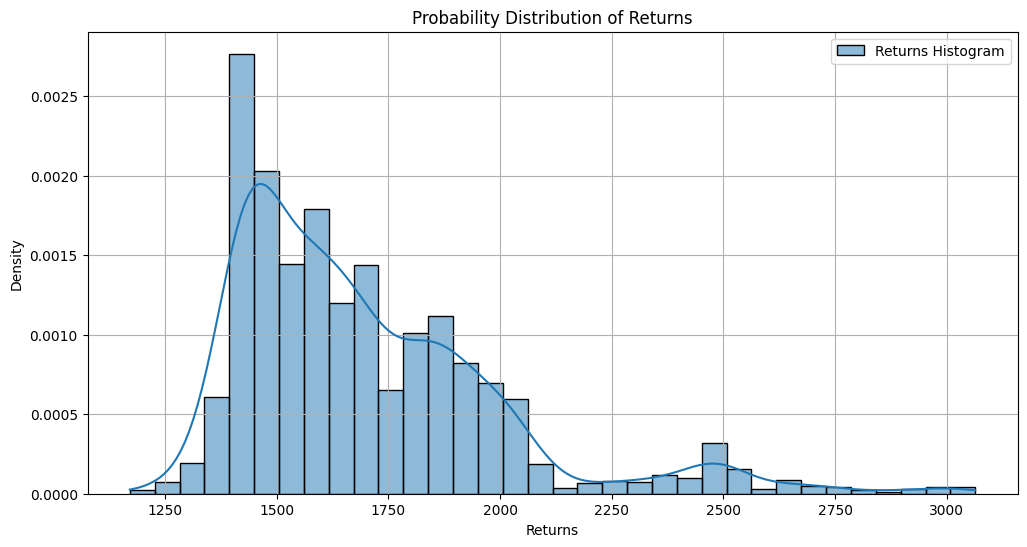

Correlation Matrix:


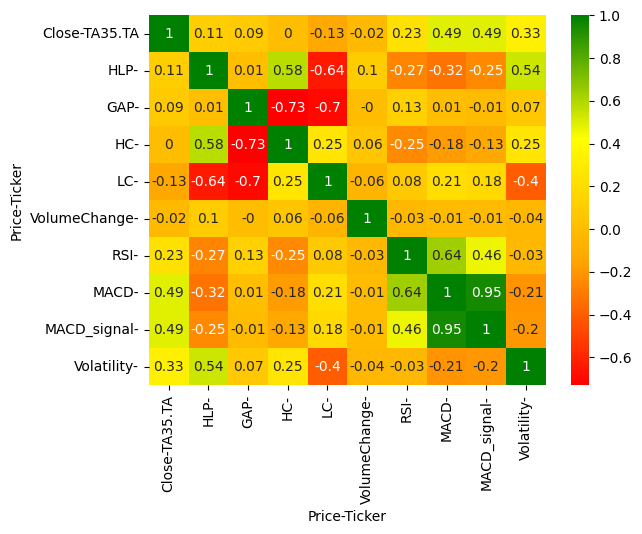

[*********************100%***********************]  5 of 5 completed


Correlation matrix of Close prices for TA35.TA and indices:

Ticker   TA35.TA   ^DJI  ^GSPC  ^IXIC   ^RUT
Ticker                                      
TA35.TA    1.000  0.806  0.845  0.802  0.690
^DJI       0.806  1.000  0.988  0.978  0.929
^GSPC      0.845  0.988  1.000  0.992  0.905
^IXIC      0.802  0.978  0.992  1.000  0.920
^RUT       0.690  0.929  0.905  0.920  1.000


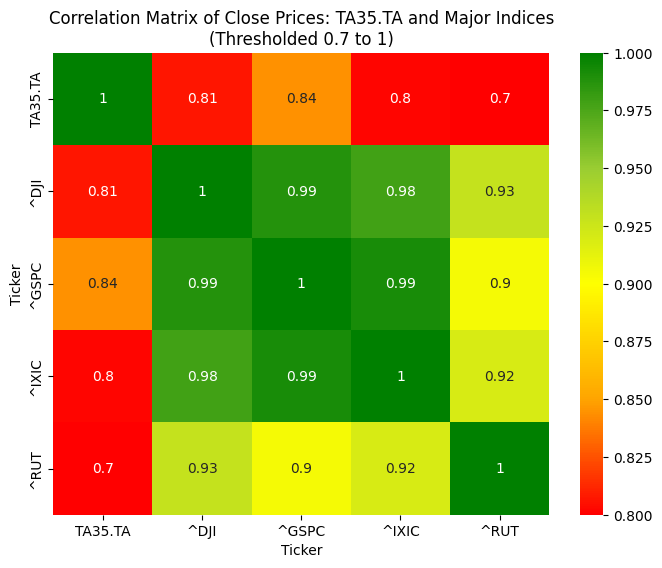


 Cleaning and preparing features...
Outliers per column:
Price         Ticker 
Close         TA35.TA    126
HLP                      111
GAP                      103
HC                       116
LC                       130
VolumeChange             117
RSI                        1
MACD                     137
MACD_signal              135
Volatility               114
dtype: int64

Dropped correlated features: [('MACD_signal', '')]

---------------------- Start Training Process ------------------------

 Start ARIMA Training TA35.TA...


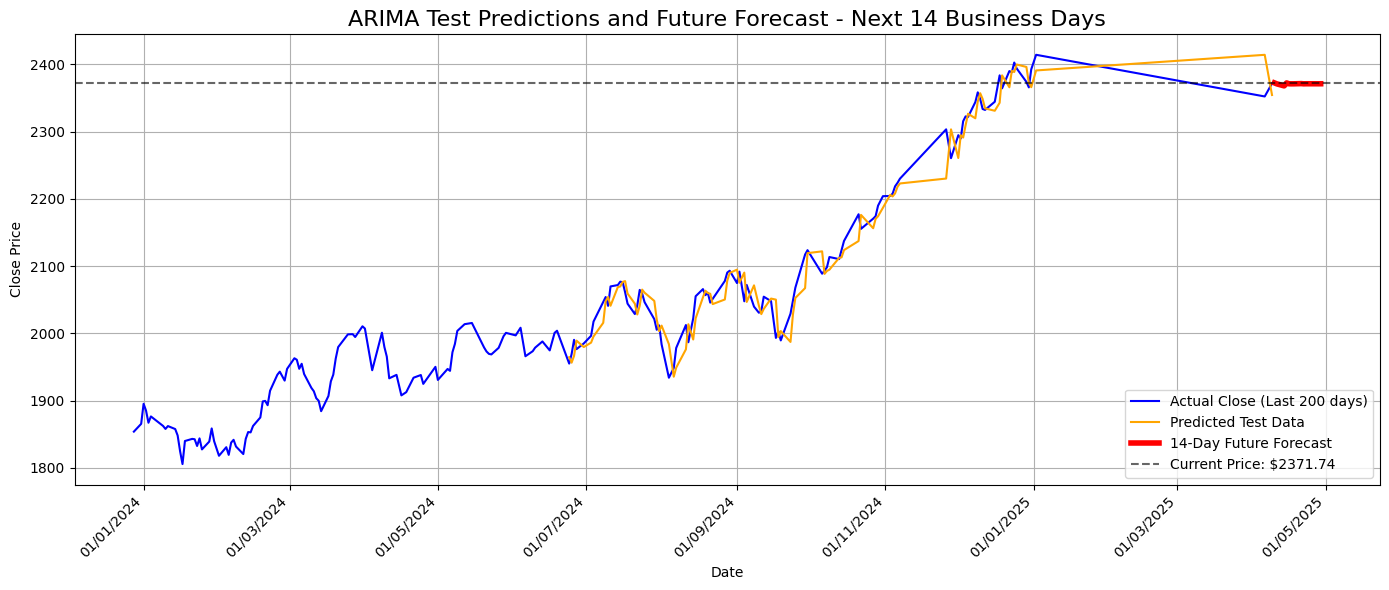


 Start XGBOOST Training
Training XGBoost model...
Making predictions on test data...

XGBoost Model Performance:
RMSE: 173.6250
R²: -0.5160
Forecasting 14 days into the future...

Top 10 Most Important Features:
             feature  importance
0   (Close, TA35.TA)    0.997913
9    (Close_lag_1, )    0.001069
54    (Close_ma_5, )    0.000324
7           (MACD, )    0.000219
10   (Close_lag_2, )    0.000050
56   (Close_ma_20, )    0.000026
16     (HLP_lag_3, )    0.000025
47    (MACD_lag_4, )    0.000014
22     (GAP_lag_4, )    0.000013
30      (LC_lag_2, )    0.000013


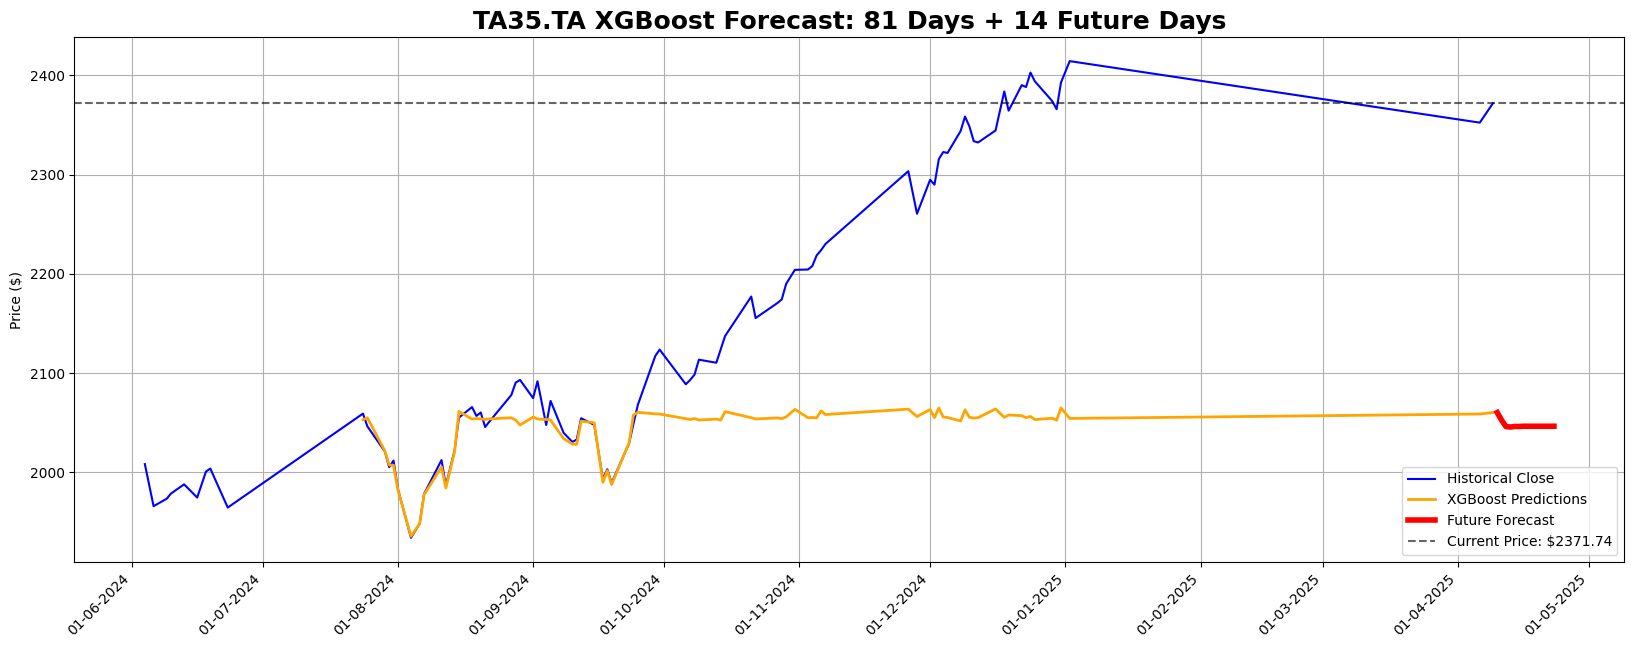


 Start LSTM Training
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step


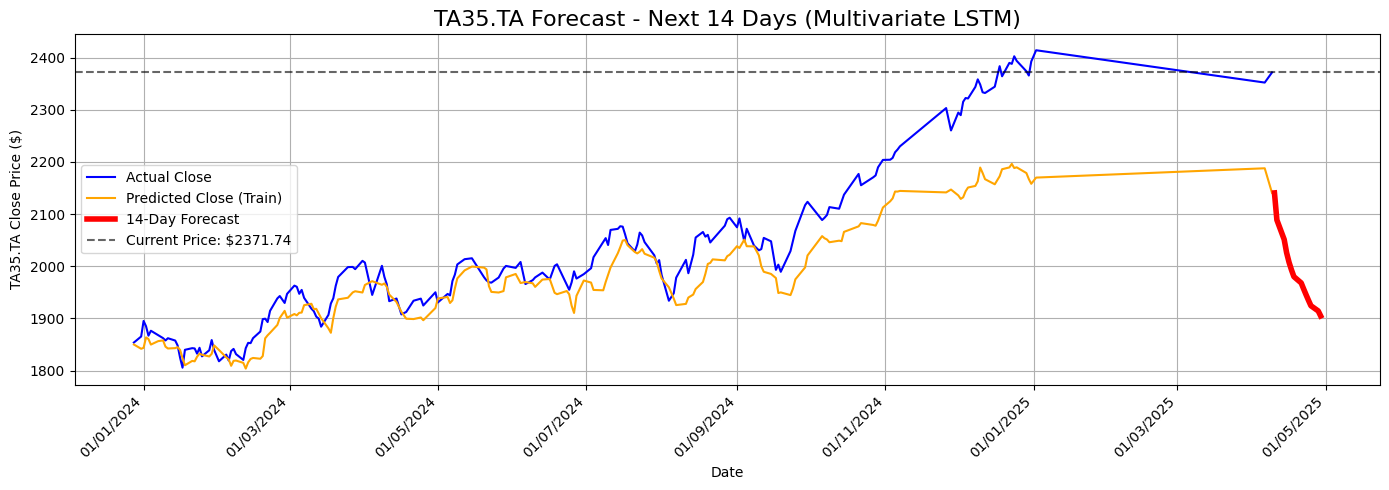


 Forecast completed using ARIMA. Evaluation Scores:

ARIMA — RMSE: 23.0776, R²: 0.9721
XGBOOST — RMSE: 173.6250, R²: -0.5160
LSTM — RMSE: 32.2640, R²: 0.9774

Run another forecast? (y/n): n
Thank you for using the Enhanced Stock Forecasting System!


In [22]:
interactive_forecast()